In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

['step', 'Monochromator-step', 'cps']


Text(0, 0.5, 'Photons (cps)')

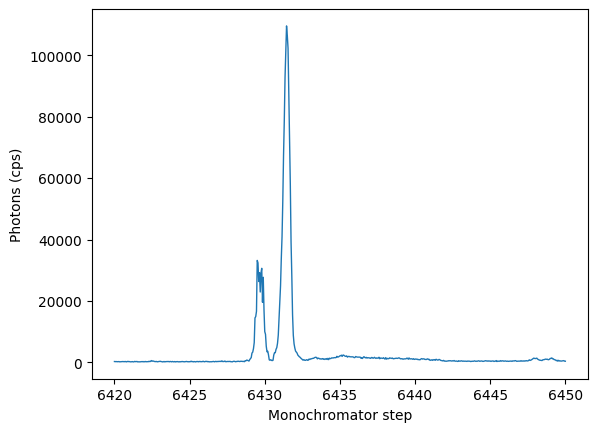

In [82]:
path =  "/Users/charlottemyers/projects/jlab/spectro/data/Nate_Charlotte_1001_Run2.txt"
df = pd.read_csv(path, sep=r"\s+")
#df = df.iloc[:, [1, 2]].rename(columns={df.columns[0]: "step", df.columns[1]: "cps"})
print(df.columns.tolist())
step = df["Monochromator-step"].to_numpy()
cps  = df["cps"].to_numpy()

plt.plot(step, cps, lw=1, label = path.split("/")[-1])
plt.xlabel("Monochromator step")
plt.ylabel("Photons (cps)")

#plt.axvline(4155, color="gray", ls="--")
#plt.xlim(640, 6440)
#plt.yscale("log")

In [61]:
# Calibration; functional form calculated in 'cal_with_Ne'

def calibrate_quad(x, a, b, c):
    return a* x**2 + b* x + c

def calibrate(x, a, b):
    return a*x + b

quad_coeff = [4.64655929e-07, 9.99421690e-01, 1.15443650e+02]
x_cal = calibrate_quad(step, *quad_coeff)


In [66]:
wls = [3835.397, 3889.064, 3970.075, 4101.734, 4340.472, 4861.35]


(3780.9981782697914, 4977.772256334368)

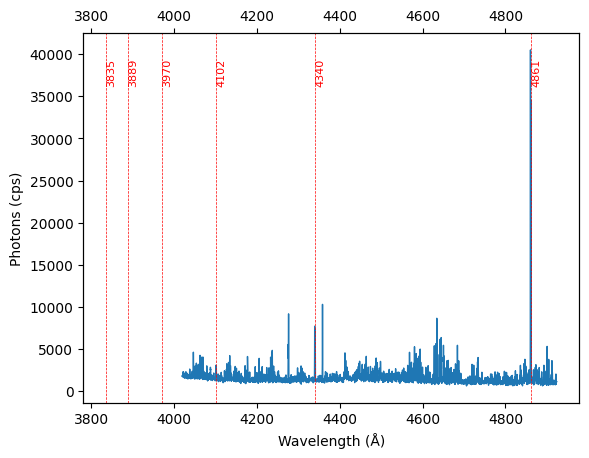

In [64]:
plt.plot(x_cal, cps, lw=1, label = "calibrated")

Balmer_lines = [3835.397, 3889.064, 3970.075, 4101.734, 4340.472, 4861.35] #, 6562.79]
for line in Balmer_lines[0:]:
    plt.axvline(line, color='red', ls='--', lw=0.5)
    plt.text(line+.5, 0.9*max(cps), f"{line:.0f}", rotation=90, fontsize = 8, color='red')

plt.xlabel("Wavelength (Å)")
plt.ylabel("Photons (cps)")

# plot second x axis in monochromator step
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
#plt.ylim(0, 1.1 * max(cps))

#plt.xlim(6550, 6580)

In [76]:
# get observed peaks
observed_peaks = x_cal[cps > np.mean(cps) + 2* np.std(cps)]
observed_steps = step[cps > np.mean(cps) + 2* np.std(cps)]
print(f"Observed peaks (wls) before averaging: {observed_peaks}")
print(f"Observed peaks (steps) before averaging: {observed_steps}")

#observed_peaks = [4102.50855454, 4341.27796045, 4862.13833799, 6561.94166725]

Observed peaks (wls) before averaging: [4046.73639609 4046.93701022 4062.98626079 4134.60894106 4177.5446956
 4235.93202774 4237.13592338 4237.33657279 4275.66129041 4275.86194695
 4276.26326014 4276.46391679 4276.66457348 4276.86523021 4339.47194386
 4339.67261222 4339.87328062 4340.67595458 4340.87662317 4341.07729179
 4358.33493229 4358.53560415 4358.73627604 4412.71836508 4464.09415226
 4568.4587199  4580.30071923 4580.50143219 4584.71641311 4591.1392727
 4593.14642413 4594.15000124 4628.07145403 4628.27217585 4631.88517488
 4632.0858974  4632.28661996 4634.29384759 4634.49457056 4636.50180228
 4642.32279529 4642.52351975 4644.7314912  4644.9322161  4650.35180247
 4650.55252841 4651.75688484 4684.07428208 4859.9299237  4860.13068845
 4860.33145323 4860.53221806 4860.73298292 4861.33527773 4861.53604273
 4861.73680778 4861.93757287 4862.13833799 4900.48515773 4900.68592999]
Observed peaks (steps) before averaging: [3926.4 3926.6 3942.6 4014.  4056.8 4115.  4116.2 4116.4 4154.6 4154.

Fitted Rydberg constant: R = 1.097638e+07 ± 9.644452e+02 m^-1


Text(0.8, 0.98, 'R_H = 1.097638e+07 ± 9.644452e+02 m^-1')

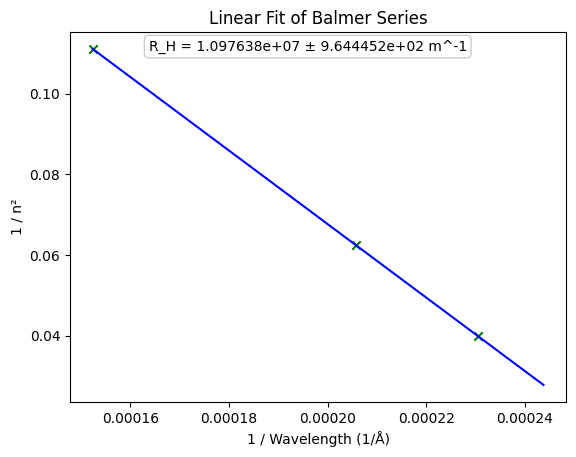

In [12]:
# fit Balmer lines to get Rydberg constant

reduced_mass = (1 * 1836.15) / (1 + 1836.15)  # in units of electron mass


def balmer_wavelength(n, R_inf):
    R_h = R_inf * reduced_mass  # Rydberg constant for hydrogen
    return 1 / (R_h * (1/2**2 - 1/n**2)) * 1e10  # in Angstroms

n_values = np.array([6, 5, 4, 3])  # corresponding n values for Balmer series lines
balmer_wavelengths = observed_peaks  # observed wavelengths in Angstroms
R_initial = 1e7  # m^-1

popt, pcov = curve_fit(balmer_wavelength, n_values, balmer_wavelengths, p0=[R_initial])
R_fit = popt[0]
R_fit_uncertainty = np.sqrt(np.diag(pcov))[0]
print(f"Fitted Rydberg constant: R = {R_fit:.6e} ± {R_fit_uncertainty:.6e} m^-1")

n_fit = np.arange(3, 6)
fitted_wavelengths = balmer_wavelength(n_fit, R_fit)
actual_wavelengths = [6562.79, 4861.35, 4340.472]  # Actual wavelengths for n=3,4,5
#plt.plot(n_fit, fitted_wavelengths, color='blue', label='Fitted Balmer Lines')
#plt.scatter(n_fit, actual_wavelengths, color='green', marker='x', label='Actual Balmer Lines')

# plot linear fit between n^2 and 1/lambda
plt.figure()
plt.plot(1/np.array(balmer_wavelengths), 1/n_values**2, color='blue', label='Data Points')
plt.scatter(1/np.array(actual_wavelengths), 1/n_fit**2, color='green', marker='x', label='Actual Balmer Lines')
plt.xlabel('1 / Wavelength (1/Å)')
plt.ylabel('1 / n²')
plt.title('Linear Fit of Balmer Series')
# annotate with Rydberg constant
plt.text(0.8, 0.98, f"R_H = {R_fit:.6e} ± {R_fit_uncertainty:.6e} m^-1",
         transform=plt.gca().transAxes, ha="right", va="top",
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.8"))